## Load libraries and modules needed in the script

In [1]:
"""
@author: Juhyeon Lee [jh0104lee@gmail.com]
        Brain Signal Processing Lab [https://bspl-ku.github.io/]
        Department of Brain and Cognitive Engineering, Korea University, Seoul, Republic of Korea
"""

import numpy as np
import tensorflow as tf
import timeit
import zipfile
import os

# # If you want to sepcify GPU device 
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

from modules_indiv_identification import init_data_params
from modules_indiv_identification import init_train_params
from modules_indiv_identification import load_data
from modules_indiv_identification import write_info
from modules_indiv_identification import init_pretrained_dnn
from modules_indiv_identification import init_dnn_last_layer
from modules_indiv_identification import init_cost_optimizer
from modules_indiv_identification import init_other_variables
from modules_indiv_identification import Hoyers_sparsity_control
from modules_indiv_identification import get_err
from modules_indiv_identification import plot_save_results

start_time = timeit.default_timer()

## Customize your model

In [2]:
# Initialize parameters related to the input data and model architecture
directory_open, subject_list, n_subjects, window_length_min, n_samples_run, n_parcels, exclude_parcels, n_units, selected_units, n_hid_layers, n_sp_layers \
 = init_data_params(directory_open='./data', subject_list=np.arange(10)+1)

# Initialize parameters related to the training and make result directory.
final_directory, n_epochs, epoch_step_show, batch_size, lr_init, lr_min, lr_beginanneal, lr_drate, tg_sp_set, beta_max, beta_lr, gamma, layer_activation, optimizer_algorithm, momentum \
 = init_train_params(directory_save='./results', epoch_step_show=10, n_epochs=200, batch_size=20, lr_init=0.001, lr_beginanneal=100, lr_drate=0.001, tg_sp_set=[0.8, 0.95], beta_max=[0.0015, 0.01])


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@         Starting         @@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@    results_20210922_113558_tgHSP_0.80-0.95    @@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


## Initialize and load data

In [3]:
# Write a text file about the overall information
write_info(final_directory, n_subjects, window_length_min, n_samples_run, n_units, n_epochs, batch_size, lr_init, lr_min, lr_beginanneal, lr_drate, beta_max, beta_lr, optimizer_algorithm)

# Load input data of DNN
x_train, y_train, x_valid, y_valid, x_test, y_test \
 = load_data(directory_open, subject_list, window_length_min, n_samples_run, selected_units)

# Number of mini-batches in an epoch
n_batches = int(np.ceil(np.size(x_train,0)/batch_size))

if ~os.path.isdir('./pretrained'):
    # Download pretrained model (~1GB) via Google drive
    !wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1MBrFIxKOW_pxbeAVshmuGp8SKakrMzkw' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1MBrFIxKOW_pxbeAVshmuGp8SKakrMzkw" -O pretrained.zip && rm -rf ~/cookies.txt
    with zipfile.ZipFile("./pretrained.zip", 'r') as zip_ref:
        zip_ref.extractall()

subject 1 loaded
subject 2 loaded
subject 3 loaded
subject 4 loaded
subject 5 loaded
subject 6 loaded
subject 7 loaded
subject 8 loaded
subject 9 loaded
subject 10 loaded
--2021-09-22 11:36:10--  https://docs.google.com/uc?export=download&confirm=aci3&id=1MBrFIxKOW_pxbeAVshmuGp8SKakrMzkw
Resolving docs.google.com (docs.google.com)... 172.217.24.142, 2404:6800:4004:821::200e
Connecting to docs.google.com (docs.google.com)|172.217.24.142|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-44-docs.googleusercontent.com/docs/securesc/ta6uvn6n9015qv5tpioo8vug07i1vo95/viand4esb7gfn66r7791o328m5iviftp/1632278100000/18124883206713037767/01644168785503989501Z/1MBrFIxKOW_pxbeAVshmuGp8SKakrMzkw?e=download [following]
--2021-09-22 11:36:11--  https://doc-04-44-docs.googleusercontent.com/docs/securesc/ta6uvn6n9015qv5tpioo8vug07i1vo95/viand4esb7gfn66r7791o328m5iviftp/1632278100000/18124883206713037767/01644168785503989501Z/1MBrFIxKOW_pxbeAVshmuGp

## Build model

In [4]:
# First, build a DNN with same structure as pretrained model (to restore pretrained Tensorflow variables easily)
X, Y, dnn, dnn_bn, dnn_bn_act, unit_vec_split_pre, n_units_pre, is_train = init_pretrained_dnn(n_units, n_hid_layers)

# Initialize operations and variables related to training
cost, optimizer, Lr, Beta, Gamma, N_batches = init_cost_optimizer(n_units_pre, unit_vec_split_pre, n_hid_layers, n_sp_layers, dnn, Y)

# Create an instance to restore variables
saver = tf.train.Saver()

# Next, substitute the last layer and its related variables with a new one for our data
Y, dnn, dnn_bn, dnn_bn_act, unit_vec_split = init_dnn_last_layer(n_units, n_hid_layers, dnn, dnn_bn, dnn_bn_act)

with tf.name_scope("new_train_test"):
    # Initialize training operations and variables again for the updated DNN structure
    cost, optimizer, Lr, Beta, Gamma, N_batches = init_cost_optimizer(n_units, unit_vec_split, n_hid_layers, n_sp_layers, dnn, Y)

    # Calculate an average error depending on how frequently classified correctly
    predict_ans = tf.argmax(dnn_bn_act[-1], 1)
    correct_ans = tf.argmax(Y, 1)
    error = 1-tf.reduce_mean(tf.cast(tf.equal(predict_ans,correct_ans), tf.float32))

# Create lists and arrays to store results obtained during training
lr, hsp, beta, beta_vec, plot_hsp, plot_beta, plot_lr, plot_tot_cost, plot_train_err, plot_val_err, plot_test_err \
 = init_other_variables(n_subjects, lr_init, n_units, n_sp_layers)



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.






## Train model

INFO:tensorflow:Restoring parameters from ./pretrained/result_model.ckpt-2000
<epoch 010> tr err: 0.008 /vd err: 0.349 /ts err: 0.268 /HSP: ['0.61', '0.95']
<epoch 020> tr err: 0.018 /vd err: 0.323 /ts err: 0.261 /HSP: ['0.59', '0.95']
<epoch 030> tr err: 0.000 /vd err: 0.109 /ts err: 0.086 /HSP: ['0.80', '0.95']
<epoch 040> tr err: 0.000 /vd err: 0.102 /ts err: 0.056 /HSP: ['0.81', '0.95']
<epoch 050> tr err: 0.000 /vd err: 0.086 /ts err: 0.046 /HSP: ['0.81', '0.95']
<epoch 060> tr err: 0.000 /vd err: 0.091 /ts err: 0.037 /HSP: ['0.81', '0.95']
<epoch 070> tr err: 0.000 /vd err: 0.088 /ts err: 0.039 /HSP: ['0.81', '0.95']
<epoch 080> tr err: 0.000 /vd err: 0.084 /ts err: 0.037 /HSP: ['0.81', '0.95']
<epoch 090> tr err: 0.000 /vd err: 0.079 /ts err: 0.037 /HSP: ['0.81', '0.95']
<epoch 100> tr err: 0.000 /vd err: 0.079 /ts err: 0.037 /HSP: ['0.81', '0.95']
<epoch 110> tr err: 0.000 /vd err: 0.077 /ts err: 0.039 /HSP: ['0.81', '0.95']
<epoch 120> tr err: 0.000 /vd err: 0.079 /ts err: 0.0

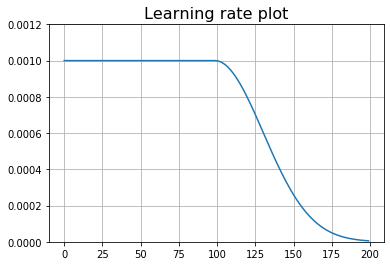

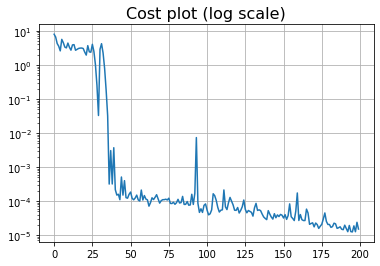

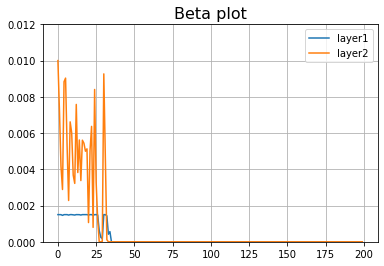

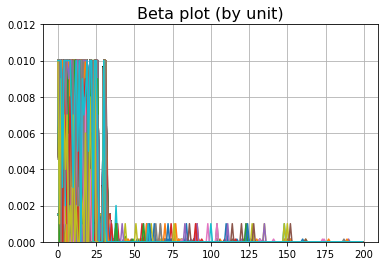

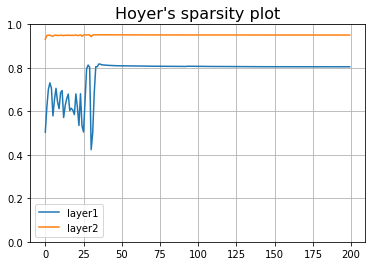

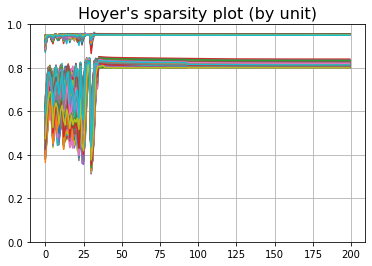

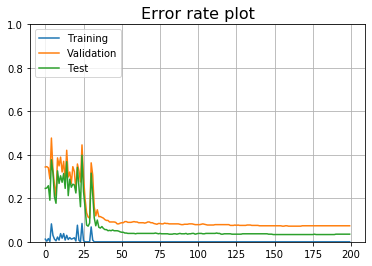

******************************* Final results **********************************
Training finished! It ran for 273.2 mins 


=> Final validation & test error rate = 0.074 & 0.035


In [5]:

################################################# Start training #################################################

init = tf.global_variables_initializer()

# Tensorflow's operations and tensors can be executed/evaluated in the session
with tf.Session(config=tf.ConfigProto(log_device_placement=False, gpu_options=tf.GPUOptions(allow_growth=True))) as sess:

    sess.run(init)

    # Restore variables of pretrained model
    saver.restore(sess, "./pretrained/result_model.ckpt-2000")

    for epoch in range(n_epochs):

        # Shuffle sample order before starting an epoch
        tr_ids_shuff = np.arange(np.size(x_train,0), dtype=int)
        np.random.shuffle(tr_ids_shuff)

        # Learning rate annealing
        if lr_beginanneal==0:
            lr = lr*1.0
        elif epoch+1 >lr_beginanneal:
            lr = max(lr_min, (-lr_drate*(epoch+1) +(1+lr_drate*lr_beginanneal))*lr)

        tot_cost_epoch = np.float32(0.0)

        # Mini-batch based training
        for batch in range(n_batches):
            if batch<(n_batches-1):
                x_batch, y_batch = x_train[tr_ids_shuff[batch*batch_size:(batch+1)*batch_size],:], \
                                   y_train[tr_ids_shuff[batch*batch_size:(batch+1)*batch_size],:]
            else:
                # for the last batch
                x_batch, y_batch = x_train[tr_ids_shuff[batch*batch_size:],:], \
                                   y_train[tr_ids_shuff[batch*batch_size:],:]

            tot_cost_batch,_ = sess.run([cost, optimizer],\
                               {Lr:lr, Beta:beta_vec, Gamma:gamma, N_batches:n_batches, is_train:True, X:x_batch, Y:y_batch})

            tot_cost_epoch += np.float32(tot_cost_batch)

            # Weight sparsity control
            for layer in range(n_sp_layers):
                w_layer = tf.get_default_graph().get_tensor_by_name(os.path.split(dnn[layer].name)[0]+'/kernel:0')
                [hsp[layer], beta[layer]] = Hoyers_sparsity_control(beta_lr[layer], sess.run(w_layer), beta[layer], beta_max[layer], tg_sp_set[layer])

            # Vectorized all beta values across layers (e.g., (2, 2000) -> (4000,))
            beta_vec = [item for sublist in beta for item in sublist]

        # Save the results to plot at a certain epoch
        plot_lr = np.hstack([plot_lr, [lr]])
        plot_tot_cost = np.hstack([plot_tot_cost, [tot_cost_epoch]])
        plot_hsp = [np.vstack([plot_hsp[layer], [np.transpose(hsp[layer])]]) for layer in range(n_sp_layers)]
        plot_beta = [np.vstack([plot_beta[layer], [np.transpose(beta[layer])]]) for layer in range(n_sp_layers)]

        # Get the classification performance
        plot_train_err, plot_val_err, plot_test_err \
            = get_err(sess, hsp, epoch, epoch_step_show, n_subjects, n_samples_run, x_train, y_train, x_valid, y_valid, x_test, y_test, \
                             plot_train_err, plot_val_err, plot_test_err,error, X, Y, is_train)


    ################################################# Finish training #################################################

    # Discard the zeroth element since it is empty
    plot_lr = plot_lr[1:]
    plot_tot_cost = plot_tot_cost[1:]
    plot_train_err = plot_train_err[:,1:]
    plot_val_err = plot_val_err[:,1:]
    plot_test_err = plot_test_err[:,1:]
    for layer in range(n_sp_layers):
        plot_beta[layer] = plot_beta[layer][1:]
        plot_hsp[layer] = plot_hsp[layer][1:]

    # Plot results and save mat files
    plot_save_results(sess, final_directory, tg_sp_set, plot_lr, plot_tot_cost, plot_train_err, plot_val_err, plot_test_err, plot_beta, plot_hsp, lr_init, beta_max, dnn, n_units, n_hid_layers, n_sp_layers)

    end_time = timeit.default_timer()

    # Save the final performance and running time in a text file
    print('******************************* Final results **********************************')
    print('Training finished! It ran for %.1f mins \n\n'%((end_time-start_time)/60))
    print('=> Final validation & test error rate = {:.3f}'.format(np.mean(plot_val_err[:,-1])),'& {:.3f}'.format(np.mean(plot_test_err[:,-1])))

    f = open(final_directory+'/final_info.txt','w')
    f.write('Training finished! It ran for %.1f mins \n\n'%((end_time-start_time)/60))
    f.write('=> Final validation & test error rate = {:.3f}'.format(np.mean(plot_val_err[:,-1]))+' & {:.3f}'.format(np.mean(plot_test_err[:,-1])))
    f.close()

